In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler as scale

In [2]:
num_epochs = 20000
show_epochs = 500
# a and b are different to the SIR model a and b.
a_value = 0.6
b_value = 0.005
LR = 0.001
seq_len = 5

# Data Preprocessing

In [3]:
train = pd.read_csv('Belgium.csv')

In [4]:
N_data = train.to_numpy()
N_normalizer = max(N_data[:,1])
S_data = train.to_numpy()
S_normalizer = max(S_data[:,3])-min(S_data[:,3])
I_data = train.to_numpy()
I_normalizer = max(I_data[:,4])-min(I_data[:,4])
R_data = train.to_numpy()
R_normalizer = max(R_data[:,5])-min(R_data[:,5])
S_N = S_normalizer/N_normalizer
I_N = I_normalizer/N_normalizer
R_N = R_normalizer/N_normalizer

In [5]:
train = train.drop("Date",axis=1)
train = train.drop("N",axis=1)
train = train.drop("D",axis=1)
sc = scale()
train_data = sc.fit_transform(train)

In [6]:
# Sliding window approach
def predictor_length(data, seq_len):
    x = list()
    y = list()
    data_length = len(data)-seq_len-1
    # Storing sequence and labels
    for i in range(data_length):
        x_bar = data[i:(i+seq_len),:]
        y_bar = data[i+seq_len,:]
        x.append(x_bar)
        y.append(y_bar)

    return np.array(x),np.array(y)

In [7]:
x, y = predictor_length(train_data, seq_len)
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))
training_size = int(len(y) * 0.70)
test_size = len(y) - training_size

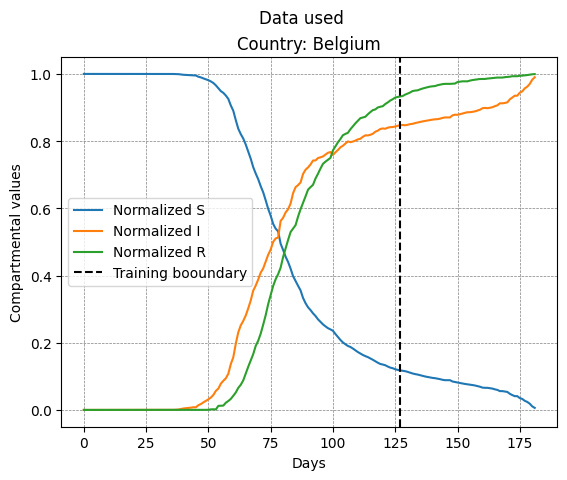

In [8]:
dataY_plot = dataY.data.numpy()
plt.plot(dataY_plot)
plt.axvline(x=training_size, c='k', linestyle='--')
plt.suptitle('Data used')
plt.title('Country: Belgium')
plt.legend(["Normalized S","Normalized I","Normalized R","Training booundary"],fontsize="10")
plt.xlabel("Days")
plt.ylabel("Compartmental values")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.savefig("Actual_Data.png")
plt.show()

# LSTM

In [9]:
generator = torch.manual_seed(0)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.lstm = nn.LSTM(input_size, hidden_size, layers, batch_first=True)
        self.fully_connected = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fully_connected(out[:, -1, :])
        return out

In [11]:
boundary = len(x)
trainX = Variable(torch.Tensor(np.array(x[0:training_size])))
trainY = Variable(torch.Tensor(np.array(y[0:training_size])))
testX = Variable(torch.Tensor(np.array(x[training_size:boundary])))
testY = Variable(torch.Tensor(np.array(y[training_size:boundary])))

In [12]:
LSTM_net = LSTM(3,30,2,3)
loss_mse = nn.MSELoss()
optimizer = optim.Adam(LSTM_net.parameters(), lr=LR)

for epoch in range(num_epochs):
    fp = LSTM_net(trainX)
    optimizer.zero_grad()
    Loss = loss_mse(fp, trainY)
    Loss.backward()
    optimizer.step()
    if epoch % show_epochs == 0:
        print("Epoch number: %d \t Loss: %1.5f" % (epoch, Loss.item()))

Epoch number: 0 	 Loss: 0.22709
Epoch number: 500 	 Loss: 0.00020
Epoch number: 1000 	 Loss: 0.00008
Epoch number: 1500 	 Loss: 0.00005
Epoch number: 2000 	 Loss: 0.00003
Epoch number: 2500 	 Loss: 0.00003
Epoch number: 3000 	 Loss: 0.00003
Epoch number: 3500 	 Loss: 0.00002
Epoch number: 4000 	 Loss: 0.00002
Epoch number: 4500 	 Loss: 0.00002
Epoch number: 5000 	 Loss: 0.00002
Epoch number: 5500 	 Loss: 0.00002
Epoch number: 6000 	 Loss: 0.00002
Epoch number: 6500 	 Loss: 0.00002
Epoch number: 7000 	 Loss: 0.00002
Epoch number: 7500 	 Loss: 0.00003
Epoch number: 8000 	 Loss: 0.00002
Epoch number: 8500 	 Loss: 0.00002
Epoch number: 9000 	 Loss: 0.00002
Epoch number: 9500 	 Loss: 0.00002
Epoch number: 10000 	 Loss: 0.00002
Epoch number: 10500 	 Loss: 0.00002
Epoch number: 11000 	 Loss: 0.00002
Epoch number: 11500 	 Loss: 0.00002
Epoch number: 12000 	 Loss: 0.00002
Epoch number: 12500 	 Loss: 0.00001
Epoch number: 13000 	 Loss: 0.00001
Epoch number: 13500 	 Loss: 0.00002
Epoch number: 14

# PINNS

In [13]:
generator = torch.manual_seed(0)

In [14]:
def PDE_Incorporated_Loss(out, input,a,b):
    S = input[:, 0]
    I = input[:, 1]
    R = input[:, 2]
    # Compute differential equations
    S_dot = -a*S*I*I_N
    I_dot = a*S*I*S_N - b*I
    R_dot = b*I*I_N/R_N

    # Define predictions
    S_new = out[:,0]
    I_new = out[:,1]
    R_new = out[:,2]
    # Compute differential equations using the predictions
    S_dot_new = -a*S_new*I_new*I_N
    I_dot_new = a*S_new*I_new*S_N - b*I_new
    R_dot_new = b*I_new*I_N/R_N

    # Compute Loss function
    temp1=torch.mean(torch.square((S_dot_new - S_dot)))
    temp2=torch.mean(torch.square((I_dot_new - I_dot)*(I_N/S_N)**2))
    temp3=torch.mean(torch.square((R_dot_new - R_dot)*(R_N/S_N)**2))
    temp4=torch.mean(torch.square(S_new - S))
    temp5=torch.mean(torch.square((I_new - I)*(I_N/S_N)**2))
    temp6=torch.mean(torch.square((R_new - R)*(R_N/S_N)**2))
    Loss = temp1 + temp2 + temp3 + temp4 + temp5 + temp6

    return Loss

In [15]:
PI_net = LSTM(3,20,2,3)
optimizer = optim.Adam(PI_net.parameters(), lr=LR)

# Train the model
for epoch in range(num_epochs):
    outputs = PI_net(trainX)
    optimizer.zero_grad()
    # obtain the Loss function
    Loss = PDE_Incorporated_Loss(outputs, trainY,a_value,b_value)

    Loss.backward()

    optimizer.step()
    if epoch % show_epochs == 0:
        print("Epoch number: %d \t Loss: %1.5f" % (epoch, Loss.item()))

Epoch number: 0 	 Loss: 0.35816
Epoch number: 500 	 Loss: 0.00037
Epoch number: 1000 	 Loss: 0.00005
Epoch number: 1500 	 Loss: 0.00004
Epoch number: 2000 	 Loss: 0.00003
Epoch number: 2500 	 Loss: 0.00003
Epoch number: 3000 	 Loss: 0.00003
Epoch number: 3500 	 Loss: 0.00003
Epoch number: 4000 	 Loss: 0.00003
Epoch number: 4500 	 Loss: 0.00003
Epoch number: 5000 	 Loss: 0.00005
Epoch number: 5500 	 Loss: 0.00002
Epoch number: 6000 	 Loss: 0.00002
Epoch number: 6500 	 Loss: 0.00002
Epoch number: 7000 	 Loss: 0.00002
Epoch number: 7500 	 Loss: 0.00002
Epoch number: 8000 	 Loss: 0.00002
Epoch number: 8500 	 Loss: 0.00002
Epoch number: 9000 	 Loss: 0.00002
Epoch number: 9500 	 Loss: 0.00002
Epoch number: 10000 	 Loss: 0.00006
Epoch number: 10500 	 Loss: 0.00002
Epoch number: 11000 	 Loss: 0.00002
Epoch number: 11500 	 Loss: 0.00001
Epoch number: 12000 	 Loss: 0.00005
Epoch number: 12500 	 Loss: 0.00001
Epoch number: 13000 	 Loss: 0.00001
Epoch number: 13500 	 Loss: 0.00001
Epoch number: 14

# Results and plots

In [16]:
# Time step update
def time_update(out,trainX):
    out = out.unsqueeze(1)
    trainX_copy_1 = trainX.clone().detach()
    trainX_copy_2 = trainX_copy_1[:,1:,:]
    t = torch.cat((trainX_copy_2,out),dim = 1)
    return t

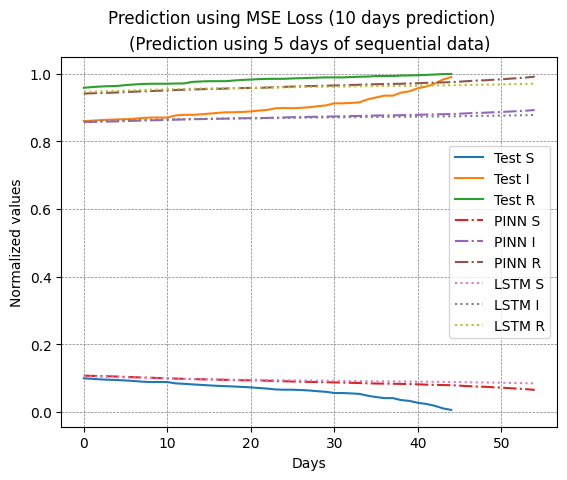

In [18]:
Data_PINN = testX
Data_LSTM = testX
Prediction_length = 10
for i in range(Prediction_length):
    # print(Data)
    predicted_1_LSTM = LSTM_net(Data_LSTM)
    Data_LSTM = time_update(predicted_1_LSTM,Data_LSTM)
    predicted_1_PINN = PI_net(Data_PINN)
    Data_PINN = time_update(predicted_1_PINN,Data_PINN)

predicted_data_PINN = predicted_1_PINN.data.numpy()
predicted_data_LSTM = predicted_1_LSTM.data.numpy()
dataY_plot = testY.data.numpy()

plt.plot(dataY_plot[Prediction_length:,:])
plt.plot(predicted_data_PINN,linestyle= "-.")
plt.plot(predicted_data_LSTM,linestyle= ":")
plt.legend(["Test S","Test I","Test R","PINN S","PINN I","PINN R","LSTM S","LSTM I","LSTM R"],fontsize="10")
plt.suptitle('Prediction using MSE Loss (10 days prediction)')
plt.title('(Prediction using 5 days of sequential data)')
plt.xlabel("Days")
plt.ylabel("Normalized values")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.savefig("MSE_Loss.png")
plt.show()

In [19]:
torch.save(PI_net,"Belgium_Prediction_PINN.pth")
torch.save(LSTM_net,"Belgium_Prediction_LSTM.pth")

In [20]:
Test_loss_LSTM = loss_mse(testY,predicted_1_LSTM)
Test_loss_PINN = loss_mse(testY,predicted_1_PINN)

In [21]:
print("Test loss [Parameters: a = %1.3f, b = %1.3f, epochs = %d, Learning rate = %1.4f, Sequence length = %d]:" % (a_value,b_value,num_epochs,LR,seq_len))
print("\tLSTM loss: %1.6f \n \tPINN loss: %1.6f" % (Test_loss_LSTM.item(),Test_loss_PINN.item()))

Test loss [Parameters: a = 0.600, b = 0.005, epochs = 20000, Learning rate = 0.0010, Sequence length = 5]:
	LSTM loss: 0.000943 
 	PINN loss: 0.000618


# Checking model applicability to other countries' data

In [23]:
# Change country names to India, Japan, Asutralia, South Africa
train = pd.read_csv('India.csv')
N_data = train.to_numpy()
N_normalizer = max(N_data[:,1])
S_data = train.to_numpy()
S_normalizer = max(S_data[:,3])-min(S_data[:,3])
I_data = train.to_numpy()
I_normalizer = max(I_data[:,4])-min(I_data[:,4])
R_data = train.to_numpy()
R_normalizer = max(R_data[:,5])-min(R_data[:,5])
train = train.drop("Date",axis=1)
train = train.drop("N",axis=1)
train = train.drop("D",axis=1)
sc = scale()
train_data = sc.fit_transform(train)

def predictor_length(data, seq_len):
    x = list()
    y = list()
    data_length = len(data)-seq_len-1
    for i in range(data_length):
        x_bar = data[i:(i+seq_len),:]
        y_bar = data[i+seq_len,:]
        x.append(x_bar)
        y.append(y_bar)
    return np.array(x),np.array(y)
x, y = predictor_length(train_data, seq_len)
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

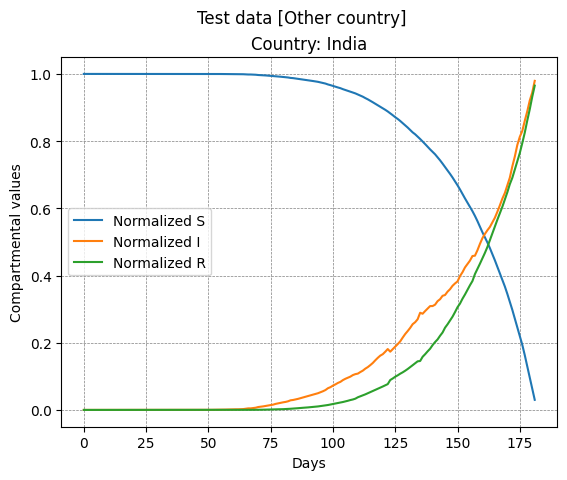

In [24]:
dataY_plot = dataY.data.numpy()
plt.plot(dataY_plot)
plt.suptitle('Test data [Other country]')
# Change title according to country
plt.title('Country: India')
plt.legend(["Normalized S","Normalized I","Normalized R"],fontsize="10")
plt.xlabel("Days")
plt.ylabel("Compartmental values")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
# plt.savefig("Actual_Data.png")
plt.show()

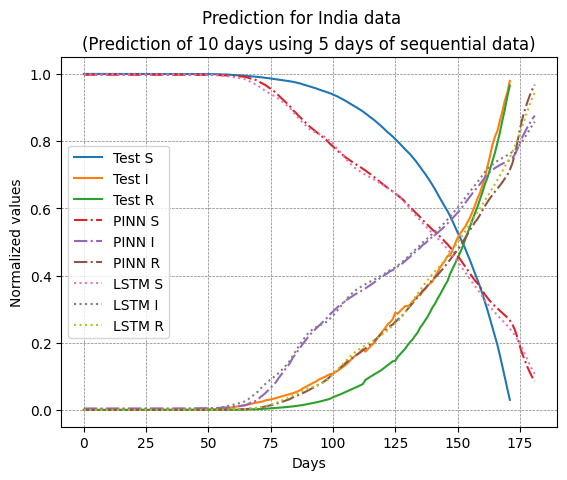

In [25]:
Data_PINN = dataX
Data_LSTM = dataX
Prediction_length = 10
for i in range(Prediction_length):
    # print(Data)
    predicted_1_LSTM = LSTM_net(Data_LSTM)
    Data_LSTM = time_update(predicted_1_LSTM,Data_LSTM)
    predicted_1_PINN = PI_net(Data_PINN)
    Data_PINN = time_update(predicted_1_PINN,Data_PINN)

predicted_data_PINN = predicted_1_PINN.data.numpy()
predicted_data_LSTM = predicted_1_LSTM.data.numpy()
dataY_plot = dataY.data.numpy()

plt.plot(dataY_plot[Prediction_length:,:])
plt.plot(predicted_data_PINN,linestyle= "-.")
plt.plot(predicted_data_LSTM,linestyle= ":")
plt.legend(["Test S","Test I","Test R","PINN S","PINN I","PINN R","LSTM S","LSTM I","LSTM R"],fontsize="10")
# Change title according to country
plt.suptitle('Prediction for India data')
plt.title('(Prediction of 10 days using 5 days of sequential data)')
plt.xlabel("Days")
plt.ylabel("Normalized values")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
# Change image name according to country
plt.savefig("India_test.png")
plt.show()